# BipedalWalker with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
#from torch.autograd import Variable
import torch.nn.functional as F

import gym
#import argparse
import os

import time
from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from collections import deque


device:  cuda


In [2]:
start_timestep=1e4

std_noise=0.1

env = gym.make('BipedalWalker-v2')

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

agent = TD3(state_dim, action_dim, max_action)


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=2000, save_every=10):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            save(agent, 'checkpnt_seed_88', 'dir_chk')  
        
        if len(scores_deque) == 100 and np.mean(scores_deque) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train()

Low in action space:  [-1. -1. -1. -1.] , High:  [1. 1. 1. 1.] , Action_dim:  4
Ep. 1, Timestep 1600,  Ep.Timesteps 1600, Score: -82.58, Avg.Score: -82.58, Time: 00:00:00 
Ep. 2, Timestep 3200,  Ep.Timesteps 1600, Score: -98.41, Avg.Score: -90.49, Time: 00:00:35 
Ep. 3, Timestep 4800,  Ep.Timesteps 1600, Score: -85.52, Avg.Score: -88.84, Time: 00:01:09 
Ep. 4, Timestep 6400,  Ep.Timesteps 1600, Score: -82.21, Avg.Score: -87.18, Time: 00:01:43 
Ep. 5, Timestep 6498,  Ep.Timesteps 98, Score: -106.43, Avg.Score: -91.03, Time: 00:02:16 
Ep. 6, Timestep 8098,  Ep.Timesteps 1600, Score: -88.20, Avg.Score: -90.56, Time: 00:02:18 
Ep. 7, Timestep 8170,  Ep.Timesteps 72, Score: -102.86, Avg.Score: -92.32, Time: 00:02:52 
Ep. 8, Timestep 8244,  Ep.Timesteps 74, Score: -101.83, Avg.Score: -93.51, Time: 00:02:54 
Ep. 9, Timestep 8308,  Ep.Timesteps 64, Score: -104.97, Avg.Score: -94.78, Time: 00:02:55 
Ep. 10, Timestep 8375,  Ep.Timesteps 67, Score: -97.59, Avg.Score: -95.06, Time: 00:02:57 
Ep. 1

Ep. 88, Timestep 20885,  Ep.Timesteps 93, Score: -101.75, Avg.Score: -109.31, Time: 00:07:34 
Ep. 89, Timestep 20968,  Ep.Timesteps 83, Score: -108.95, Avg.Score: -109.30, Time: 00:07:36 
Ep. 90, Timestep 21102,  Ep.Timesteps 134, Score: -94.90, Avg.Score: -109.14, Time: 00:07:38 
Ep. 91, Timestep 21171,  Ep.Timesteps 69, Score: -107.65, Avg.Score: -109.13, Time: 00:07:41 
Ep. 92, Timestep 21598,  Ep.Timesteps 427, Score: -139.46, Avg.Score: -109.46, Time: 00:07:43 
Ep. 93, Timestep 21832,  Ep.Timesteps 234, Score: -111.43, Avg.Score: -109.48, Time: 00:07:52 
Ep. 94, Timestep 23432,  Ep.Timesteps 1600, Score: -87.78, Avg.Score: -109.25, Time: 00:07:59 
Ep. 95, Timestep 23515,  Ep.Timesteps 83, Score: -128.14, Avg.Score: -109.45, Time: 00:08:33 
Ep. 96, Timestep 23577,  Ep.Timesteps 62, Score: -118.00, Avg.Score: -109.54, Time: 00:08:34 
Ep. 97, Timestep 23759,  Ep.Timesteps 182, Score: -136.98, Avg.Score: -109.82, Time: 00:08:36 
Ep. 98, Timestep 23901,  Ep.Timesteps 142, Score: -108.5

Ep. 174, Timestep 70115,  Ep.Timesteps 106, Score: -130.96, Avg.Score: -114.80, Time: 00:25:53 
Ep. 175, Timestep 70261,  Ep.Timesteps 146, Score: -106.86, Avg.Score: -114.82, Time: 00:25:56 
Ep. 176, Timestep 70306,  Ep.Timesteps 45, Score: -113.33, Avg.Score: -114.74, Time: 00:25:59 
Ep. 177, Timestep 70355,  Ep.Timesteps 49, Score: -113.37, Avg.Score: -114.84, Time: 00:26:00 
Ep. 178, Timestep 70466,  Ep.Timesteps 111, Score: -132.34, Avg.Score: -115.12, Time: 00:26:01 
Ep. 179, Timestep 70615,  Ep.Timesteps 149, Score: -134.76, Avg.Score: -115.58, Time: 00:26:03 
Ep. 180, Timestep 72215,  Ep.Timesteps 1600, Score: -31.85, Avg.Score: -114.84, Time: 00:26:09 
Ep. 181, Timestep 73815,  Ep.Timesteps 1600, Score: -75.62, Avg.Score: -114.37, Time: 00:26:44 
Ep. 182, Timestep 75415,  Ep.Timesteps 1600, Score: -93.24, Avg.Score: -114.11, Time: 00:27:20 
Ep. 183, Timestep 75584,  Ep.Timesteps 169, Score: -109.49, Avg.Score: -113.85, Time: 00:27:53 
Ep. 184, Timestep 77184,  Ep.Timesteps 160

Ep. 259, Timestep 151763,  Ep.Timesteps 171, Score: -99.35, Avg.Score: -101.25, Time: 00:56:31 
Ep. 260, Timestep 152008,  Ep.Timesteps 245, Score: -95.63, Avg.Score: -100.87, Time: 00:56:35 
Ep. 261, Timestep 152126,  Ep.Timesteps 118, Score: -100.25, Avg.Score: -100.77, Time: 00:56:40 
Ep. 262, Timestep 153256,  Ep.Timesteps 1130, Score: -132.95, Avg.Score: -101.00, Time: 00:56:44 
Ep. 263, Timestep 154585,  Ep.Timesteps 1329, Score: -110.37, Avg.Score: -100.90, Time: 00:57:09 
Ep. 264, Timestep 154683,  Ep.Timesteps 98, Score: -97.47, Avg.Score: -100.76, Time: 00:57:37 
Ep. 265, Timestep 154759,  Ep.Timesteps 76, Score: -99.03, Avg.Score: -100.43, Time: 00:57:39 
Ep. 266, Timestep 154852,  Ep.Timesteps 93, Score: -96.74, Avg.Score: -99.95, Time: 00:57:41 
Ep. 267, Timestep 154973,  Ep.Timesteps 121, Score: -96.16, Avg.Score: -99.74, Time: 00:57:43 
Ep. 268, Timestep 156573,  Ep.Timesteps 1600, Score: -53.45, Avg.Score: -99.12, Time: 00:57:47 
Ep. 269, Timestep 156709,  Ep.Timesteps 

Ep. 345, Timestep 264341,  Ep.Timesteps 1581, Score: 242.48, Avg.Score: 12.89, Time: 01:37:13 
Ep. 346, Timestep 265941,  Ep.Timesteps 1600, Score: 195.05, Avg.Score: 15.88, Time: 01:37:48 
Ep. 347, Timestep 267541,  Ep.Timesteps 1600, Score: 226.58, Avg.Score: 19.34, Time: 01:38:23 
Ep. 348, Timestep 269127,  Ep.Timesteps 1586, Score: 244.17, Avg.Score: 23.05, Time: 01:38:58 
Ep. 349, Timestep 270551,  Ep.Timesteps 1424, Score: 261.89, Avg.Score: 26.60, Time: 01:39:33 
Ep. 350, Timestep 272059,  Ep.Timesteps 1508, Score: 254.25, Avg.Score: 30.12, Time: 01:40:04 
Ep. 351, Timestep 273659,  Ep.Timesteps 1600, Score: 245.81, Avg.Score: 32.89, Time: 01:40:37 
Ep. 352, Timestep 275158,  Ep.Timesteps 1499, Score: 252.57, Avg.Score: 36.01, Time: 01:41:12 
Ep. 353, Timestep 276758,  Ep.Timesteps 1600, Score: 237.72, Avg.Score: 39.38, Time: 01:41:45 
Ep. 354, Timestep 276959,  Ep.Timesteps 201, Score: -88.83, Avg.Score: 39.46, Time: 01:42:19 
Ep. 355, Timestep 278559,  Ep.Timesteps 1600, Score

Ep. 431, Timestep 362771,  Ep.Timesteps 378, Score: -47.59, Avg.Score: 184.46, Time: 02:13:46 
Ep. 432, Timestep 363210,  Ep.Timesteps 439, Score: -59.14, Avg.Score: 181.77, Time: 02:13:54 
Ep. 433, Timestep 364384,  Ep.Timesteps 1174, Score: 275.58, Avg.Score: 182.69, Time: 02:14:05 
Ep. 434, Timestep 365569,  Ep.Timesteps 1185, Score: 280.74, Avg.Score: 183.96, Time: 02:14:30 
Ep. 435, Timestep 366750,  Ep.Timesteps 1181, Score: 275.65, Avg.Score: 185.31, Time: 02:14:57 
Ep. 436, Timestep 367982,  Ep.Timesteps 1232, Score: 282.39, Avg.Score: 186.09, Time: 02:15:23 
Ep. 437, Timestep 369134,  Ep.Timesteps 1152, Score: 278.96, Avg.Score: 187.00, Time: 02:15:50 
Ep. 438, Timestep 370424,  Ep.Timesteps 1290, Score: 147.32, Avg.Score: 186.73, Time: 02:16:15 
Ep. 439, Timestep 371554,  Ep.Timesteps 1130, Score: 289.12, Avg.Score: 187.41, Time: 02:16:43 
Ep. 440, Timestep 372667,  Ep.Timesteps 1113, Score: 290.51, Avg.Score: 188.18, Time: 02:17:08 
Ep. 441, Timestep 373804,  Ep.Timesteps 11

Ep. 517, Timestep 452601,  Ep.Timesteps 1041, Score: 281.61, Avg.Score: 251.49, Time: 02:46:28 
Ep. 518, Timestep 452810,  Ep.Timesteps 209, Score: -98.44, Avg.Score: 247.74, Time: 02:46:50 
Ep. 519, Timestep 453872,  Ep.Timesteps 1062, Score: 282.33, Avg.Score: 247.82, Time: 02:46:56 
Ep. 520, Timestep 454921,  Ep.Timesteps 1049, Score: 283.46, Avg.Score: 247.87, Time: 02:47:19 
Ep. 521, Timestep 455931,  Ep.Timesteps 1010, Score: 283.66, Avg.Score: 247.93, Time: 02:47:42 
Ep. 522, Timestep 457020,  Ep.Timesteps 1089, Score: 282.98, Avg.Score: 247.92, Time: 02:48:05 
Ep. 523, Timestep 458056,  Ep.Timesteps 1036, Score: 285.00, Avg.Score: 247.97, Time: 02:48:28 
Ep. 524, Timestep 458987,  Ep.Timesteps 931, Score: -13.44, Avg.Score: 245.04, Time: 02:48:51 
Ep. 525, Timestep 459331,  Ep.Timesteps 344, Score: -35.87, Avg.Score: 245.23, Time: 02:49:11 
Ep. 526, Timestep 460381,  Ep.Timesteps 1050, Score: 289.51, Avg.Score: 245.36, Time: 02:49:20 
Ep. 527, Timestep 461392,  Ep.Timesteps 101

Ep. 603, Timestep 537713,  Ep.Timesteps 1033, Score: 292.06, Avg.Score: 262.53, Time: 03:17:42 
Ep. 604, Timestep 538756,  Ep.Timesteps 1043, Score: 289.80, Avg.Score: 265.02, Time: 03:18:05 
Ep. 605, Timestep 539807,  Ep.Timesteps 1051, Score: 280.97, Avg.Score: 264.91, Time: 03:18:28 
Ep. 606, Timestep 540774,  Ep.Timesteps 967, Score: 285.48, Avg.Score: 264.97, Time: 03:18:52 
Ep. 607, Timestep 541768,  Ep.Timesteps 994, Score: 284.87, Avg.Score: 264.97, Time: 03:19:15 
Ep. 608, Timestep 542786,  Ep.Timesteps 1018, Score: 284.21, Avg.Score: 264.94, Time: 03:19:37 
Ep. 609, Timestep 543772,  Ep.Timesteps 986, Score: 286.10, Avg.Score: 264.97, Time: 03:19:59 
Ep. 610, Timestep 544793,  Ep.Timesteps 1021, Score: 287.11, Avg.Score: 268.35, Time: 03:20:21 
Ep. 611, Timestep 545806,  Ep.Timesteps 1013, Score: 292.21, Avg.Score: 268.42, Time: 03:20:43 
Ep. 612, Timestep 546830,  Ep.Timesteps 1024, Score: 290.66, Avg.Score: 271.40, Time: 03:21:06 
Ep. 613, Timestep 547857,  Ep.Timesteps 102

Ep. 689, Timestep 623457,  Ep.Timesteps 944, Score: 293.20, Avg.Score: 284.45, Time: 03:50:36 
Ep. 690, Timestep 624408,  Ep.Timesteps 951, Score: 289.38, Avg.Score: 284.42, Time: 03:50:57 
Ep. 691, Timestep 625344,  Ep.Timesteps 936, Score: 294.82, Avg.Score: 284.40, Time: 03:51:19 
Ep. 692, Timestep 626307,  Ep.Timesteps 963, Score: 289.92, Avg.Score: 284.38, Time: 03:51:39 
Ep. 693, Timestep 627308,  Ep.Timesteps 1001, Score: 287.95, Avg.Score: 284.31, Time: 03:52:01 
Ep. 694, Timestep 628291,  Ep.Timesteps 983, Score: 287.60, Avg.Score: 284.26, Time: 03:52:23 
Ep. 695, Timestep 629283,  Ep.Timesteps 992, Score: 291.42, Avg.Score: 284.25, Time: 03:52:44 
Ep. 696, Timestep 630252,  Ep.Timesteps 969, Score: 289.22, Avg.Score: 284.25, Time: 03:53:06 
Ep. 697, Timestep 631229,  Ep.Timesteps 977, Score: 293.40, Avg.Score: 284.32, Time: 03:53:28 
Ep. 698, Timestep 632190,  Ep.Timesteps 961, Score: 290.00, Avg.Score: 284.32, Time: 03:53:49 
Ep. 699, Timestep 633144,  Ep.Timesteps 954, Scor

Ep. 776, Timestep 706932,  Ep.Timesteps 933, Score: 296.38, Avg.Score: 287.09, Time: 04:21:23 
Ep. 777, Timestep 707902,  Ep.Timesteps 970, Score: 293.63, Avg.Score: 287.12, Time: 04:21:43 
Ep. 778, Timestep 708843,  Ep.Timesteps 941, Score: 292.10, Avg.Score: 287.14, Time: 04:22:05 
Ep. 779, Timestep 709815,  Ep.Timesteps 972, Score: 292.02, Avg.Score: 287.15, Time: 04:22:25 
Ep. 780, Timestep 710752,  Ep.Timesteps 937, Score: 296.81, Avg.Score: 287.21, Time: 04:22:47 
Ep. 781, Timestep 711699,  Ep.Timesteps 947, Score: 293.41, Avg.Score: 287.24, Time: 04:23:08 
Ep. 782, Timestep 712647,  Ep.Timesteps 948, Score: 294.63, Avg.Score: 290.20, Time: 04:23:28 
Ep. 783, Timestep 713585,  Ep.Timesteps 938, Score: 295.08, Avg.Score: 290.21, Time: 04:23:49 
Ep. 784, Timestep 714544,  Ep.Timesteps 959, Score: 294.49, Avg.Score: 290.18, Time: 04:24:10 
Ep. 785, Timestep 715512,  Ep.Timesteps 968, Score: 295.88, Avg.Score: 290.19, Time: 04:24:31 
Ep. 786, Timestep 716443,  Ep.Timesteps 931, Score

Ep. 863, Timestep 787080,  Ep.Timesteps 909, Score: 299.40, Avg.Score: 291.51, Time: 04:50:57 
Ep. 864, Timestep 788062,  Ep.Timesteps 982, Score: 294.33, Avg.Score: 291.45, Time: 04:51:17 
Ep. 865, Timestep 789011,  Ep.Timesteps 949, Score: 294.35, Avg.Score: 291.40, Time: 04:51:39 
Ep. 866, Timestep 789969,  Ep.Timesteps 958, Score: 293.73, Avg.Score: 291.36, Time: 04:51:59 
Ep. 867, Timestep 790900,  Ep.Timesteps 931, Score: 300.82, Avg.Score: 291.48, Time: 04:52:21 
Ep. 868, Timestep 791796,  Ep.Timesteps 896, Score: 298.31, Avg.Score: 291.49, Time: 04:52:41 
Ep. 869, Timestep 792739,  Ep.Timesteps 943, Score: 297.22, Avg.Score: 291.55, Time: 04:53:02 
Ep. 870, Timestep 793687,  Ep.Timesteps 948, Score: 296.46, Avg.Score: 291.57, Time: 04:53:25 
Ep. 871, Timestep 794637,  Ep.Timesteps 950, Score: 292.41, Avg.Score: 291.58, Time: 04:53:48 
Ep. 872, Timestep 795624,  Ep.Timesteps 987, Score: 289.32, Avg.Score: 291.52, Time: 04:54:12 
Ep. 873, Timestep 796527,  Ep.Timesteps 903, Score

Ep. 950, Timestep 865797,  Ep.Timesteps 888, Score: 291.52, Avg.Score: 293.99, Time: 05:20:04 
Ep. 951, Timestep 866675,  Ep.Timesteps 878, Score: 291.05, Avg.Score: 293.93, Time: 05:20:24 
Ep. 952, Timestep 867606,  Ep.Timesteps 931, Score: 290.59, Avg.Score: 293.91, Time: 05:20:44 
Ep. 953, Timestep 868506,  Ep.Timesteps 900, Score: 293.26, Avg.Score: 293.95, Time: 05:21:04 
Ep. 954, Timestep 869391,  Ep.Timesteps 885, Score: 296.87, Avg.Score: 294.03, Time: 05:21:24 
Ep. 955, Timestep 870288,  Ep.Timesteps 897, Score: 294.52, Avg.Score: 294.04, Time: 05:21:44 
Ep. 956, Timestep 871178,  Ep.Timesteps 890, Score: 290.47, Avg.Score: 293.98, Time: 05:22:03 
Ep. 957, Timestep 872083,  Ep.Timesteps 905, Score: 291.08, Avg.Score: 293.93, Time: 05:22:23 
Ep. 958, Timestep 872975,  Ep.Timesteps 892, Score: 294.32, Avg.Score: 293.91, Time: 05:22:43 
Ep. 959, Timestep 873902,  Ep.Timesteps 927, Score: 290.35, Avg.Score: 293.84, Time: 05:23:03 
Ep. 960, Timestep 874802,  Ep.Timesteps 900, Score

Ep. 1036, Timestep 942565,  Ep.Timesteps 844, Score: 294.33, Avg.Score: 290.05, Time: 05:48:20 
Ep. 1037, Timestep 943399,  Ep.Timesteps 834, Score: 299.93, Avg.Score: 290.15, Time: 05:48:39 
Ep. 1038, Timestep 944280,  Ep.Timesteps 881, Score: 297.76, Avg.Score: 290.17, Time: 05:48:57 
Ep. 1039, Timestep 945149,  Ep.Timesteps 869, Score: 295.78, Avg.Score: 290.14, Time: 05:49:17 
Ep. 1040, Timestep 946021,  Ep.Timesteps 872, Score: 294.30, Avg.Score: 290.18, Time: 05:49:36 
Ep. 1041, Timestep 946909,  Ep.Timesteps 888, Score: 291.72, Avg.Score: 290.18, Time: 05:49:55 
Ep. 1042, Timestep 947839,  Ep.Timesteps 930, Score: 288.40, Avg.Score: 290.12, Time: 05:50:14 
Ep. 1043, Timestep 948722,  Ep.Timesteps 883, Score: 294.76, Avg.Score: 290.11, Time: 05:50:35 
Ep. 1044, Timestep 949589,  Ep.Timesteps 867, Score: 291.13, Avg.Score: 290.03, Time: 05:50:54 
Ep. 1045, Timestep 950475,  Ep.Timesteps 886, Score: 292.41, Avg.Score: 289.99, Time: 05:51:13 
Ep. 1046, Timestep 951353,  Ep.Timesteps

Ep. 1122, Timestep 1018229,  Ep.Timesteps 904, Score: 291.26, Avg.Score: 287.88, Time: 06:17:57 
Ep. 1123, Timestep 1019129,  Ep.Timesteps 900, Score: 289.35, Avg.Score: 287.85, Time: 06:18:18 
Ep. 1124, Timestep 1020010,  Ep.Timesteps 881, Score: 292.98, Avg.Score: 287.82, Time: 06:18:38 
Ep. 1125, Timestep 1020858,  Ep.Timesteps 848, Score: 298.63, Avg.Score: 287.87, Time: 06:18:59 
Ep. 1126, Timestep 1021762,  Ep.Timesteps 904, Score: 295.38, Avg.Score: 287.90, Time: 06:19:35 
Ep. 1127, Timestep 1022628,  Ep.Timesteps 866, Score: 294.85, Avg.Score: 288.03, Time: 06:20:09 
Ep. 1128, Timestep 1023512,  Ep.Timesteps 884, Score: 293.46, Avg.Score: 288.03, Time: 06:20:29 
Ep. 1129, Timestep 1024412,  Ep.Timesteps 900, Score: 293.85, Avg.Score: 288.07, Time: 06:20:49 
Ep. 1130, Timestep 1025276,  Ep.Timesteps 864, Score: 297.03, Avg.Score: 288.14, Time: 06:21:10 
Ep. 1131, Timestep 1026166,  Ep.Timesteps 890, Score: 290.72, Avg.Score: 288.13, Time: 06:21:29 
Ep. 1132, Timestep 1027037,  E

Ep. 1207, Timestep 1092639,  Ep.Timesteps 848, Score: 299.33, Avg.Score: 290.67, Time: 06:46:00 
Ep. 1208, Timestep 1093485,  Ep.Timesteps 846, Score: 300.12, Avg.Score: 290.77, Time: 06:46:19 
Ep. 1209, Timestep 1094339,  Ep.Timesteps 854, Score: 294.92, Avg.Score: 290.83, Time: 06:46:38 
Ep. 1210, Timestep 1095224,  Ep.Timesteps 885, Score: 292.62, Avg.Score: 290.89, Time: 06:46:57 
Ep. 1211, Timestep 1096110,  Ep.Timesteps 886, Score: 298.04, Avg.Score: 290.95, Time: 06:47:16 
Ep. 1212, Timestep 1096940,  Ep.Timesteps 830, Score: 297.28, Avg.Score: 290.99, Time: 06:47:36 
Ep. 1213, Timestep 1097768,  Ep.Timesteps 828, Score: 304.78, Avg.Score: 291.08, Time: 06:47:54 
Ep. 1214, Timestep 1098640,  Ep.Timesteps 872, Score: 294.26, Avg.Score: 291.06, Time: 06:48:12 
Ep. 1215, Timestep 1099461,  Ep.Timesteps 821, Score: 303.85, Avg.Score: 291.18, Time: 06:48:31 
Ep. 1216, Timestep 1100316,  Ep.Timesteps 855, Score: 305.47, Avg.Score: 291.26, Time: 06:48:50 
Ep. 1217, Timestep 1101245,  E

Ep. 1292, Timestep 1162214,  Ep.Timesteps 833, Score: 293.30, Avg.Score: 272.96, Time: 07:11:38 
Ep. 1293, Timestep 1163069,  Ep.Timesteps 855, Score: 290.40, Avg.Score: 272.88, Time: 07:11:56 
Ep. 1294, Timestep 1163894,  Ep.Timesteps 825, Score: 298.98, Avg.Score: 272.93, Time: 07:12:15 
Ep. 1295, Timestep 1164253,  Ep.Timesteps 359, Score: 20.55, Avg.Score: 270.18, Time: 07:12:32 
Ep. 1296, Timestep 1165048,  Ep.Timesteps 795, Score: 295.94, Avg.Score: 270.16, Time: 07:12:41 
Ep. 1297, Timestep 1165428,  Ep.Timesteps 380, Score: 19.89, Avg.Score: 267.43, Time: 07:12:58 
Ep. 1298, Timestep 1165667,  Ep.Timesteps 239, Score: -33.84, Avg.Score: 264.15, Time: 07:13:06 
Ep. 1299, Timestep 1166493,  Ep.Timesteps 826, Score: 300.34, Avg.Score: 264.22, Time: 07:13:12 
Ep. 1300, Timestep 1167324,  Ep.Timesteps 831, Score: 300.22, Avg.Score: 264.29, Time: 07:13:31 
Ep. 1301, Timestep 1168175,  Ep.Timesteps 851, Score: 292.45, Avg.Score: 264.28, Time: 07:13:49 
Ep. 1302, Timestep 1169040,  Ep.

Ep. 1377, Timestep 1226184,  Ep.Timesteps 852, Score: 299.16, Avg.Score: 246.88, Time: 07:35:10 
Ep. 1378, Timestep 1227052,  Ep.Timesteps 868, Score: 295.61, Avg.Score: 246.86, Time: 07:35:29 
Ep. 1379, Timestep 1227947,  Ep.Timesteps 895, Score: 294.28, Avg.Score: 246.84, Time: 07:35:49 
Ep. 1380, Timestep 1228827,  Ep.Timesteps 880, Score: 297.99, Avg.Score: 246.83, Time: 07:36:08 
Ep. 1381, Timestep 1228911,  Ep.Timesteps 84, Score: -100.28, Avg.Score: 242.87, Time: 07:36:27 
Ep. 1382, Timestep 1229753,  Ep.Timesteps 842, Score: 295.64, Avg.Score: 242.83, Time: 07:36:30 
Ep. 1383, Timestep 1229856,  Ep.Timesteps 103, Score: -91.70, Avg.Score: 238.94, Time: 07:36:47 
Ep. 1384, Timestep 1230712,  Ep.Timesteps 856, Score: 294.04, Avg.Score: 238.96, Time: 07:36:51 
Ep. 1385, Timestep 1231546,  Ep.Timesteps 834, Score: 295.90, Avg.Score: 239.00, Time: 07:37:10 
Ep. 1386, Timestep 1232399,  Ep.Timesteps 853, Score: 292.25, Avg.Score: 238.99, Time: 07:37:28 
Ep. 1387, Timestep 1233226,  E

Ep. 1462, Timestep 1294036,  Ep.Timesteps 785, Score: 304.77, Avg.Score: 279.70, Time: 08:00:52 
Ep. 1463, Timestep 1294834,  Ep.Timesteps 798, Score: 302.67, Avg.Score: 279.77, Time: 08:01:09 
Ep. 1464, Timestep 1295626,  Ep.Timesteps 792, Score: 302.51, Avg.Score: 279.88, Time: 08:01:27 
Ep. 1465, Timestep 1296462,  Ep.Timesteps 836, Score: 300.07, Avg.Score: 279.92, Time: 08:01:45 
Ep. 1466, Timestep 1297276,  Ep.Timesteps 814, Score: 301.78, Avg.Score: 279.97, Time: 08:02:04 
Ep. 1467, Timestep 1298077,  Ep.Timesteps 801, Score: 301.02, Avg.Score: 280.01, Time: 08:02:22 
Ep. 1468, Timestep 1298863,  Ep.Timesteps 786, Score: 303.47, Avg.Score: 280.11, Time: 08:02:40 
Ep. 1469, Timestep 1299724,  Ep.Timesteps 861, Score: 299.75, Avg.Score: 280.17, Time: 08:02:57 
Ep. 1470, Timestep 1300596,  Ep.Timesteps 872, Score: 297.82, Avg.Score: 280.19, Time: 08:03:17 
Ep. 1471, Timestep 1301481,  Ep.Timesteps 885, Score: 296.62, Avg.Score: 280.20, Time: 08:03:37 
Ep. 1472, Timestep 1302301,  E

Ep. 1547, Timestep 1365667,  Ep.Timesteps 856, Score: 296.84, Avg.Score: 288.77, Time: 08:30:29 
Ep. 1548, Timestep 1366571,  Ep.Timesteps 904, Score: 295.08, Avg.Score: 288.74, Time: 08:30:51 
Ep. 1549, Timestep 1367385,  Ep.Timesteps 814, Score: 301.79, Avg.Score: 289.93, Time: 08:31:13 
Ep. 1550, Timestep 1367625,  Ep.Timesteps 240, Score: -27.02, Avg.Score: 286.67, Time: 08:31:32 
Ep. 1551, Timestep 1367886,  Ep.Timesteps 261, Score: -18.61, Avg.Score: 283.49, Time: 08:31:37 
Ep. 1552, Timestep 1368707,  Ep.Timesteps 821, Score: 299.46, Avg.Score: 283.44, Time: 08:31:44 
Ep. 1553, Timestep 1369583,  Ep.Timesteps 876, Score: 296.36, Avg.Score: 283.43, Time: 08:32:02 
Ep. 1554, Timestep 1370413,  Ep.Timesteps 830, Score: 298.12, Avg.Score: 283.38, Time: 08:32:24 
Ep. 1555, Timestep 1371256,  Ep.Timesteps 843, Score: 296.08, Avg.Score: 283.34, Time: 08:32:43 
Ep. 1556, Timestep 1372087,  Ep.Timesteps 831, Score: 297.82, Avg.Score: 283.31, Time: 08:33:02 
Ep. 1557, Timestep 1372855,  E

Ep. 1632, Timestep 1432402,  Ep.Timesteps 780, Score: 298.51, Avg.Score: 270.20, Time: 08:56:57 
Ep. 1633, Timestep 1433226,  Ep.Timesteps 824, Score: 302.25, Avg.Score: 270.16, Time: 08:57:14 
Ep. 1634, Timestep 1434021,  Ep.Timesteps 795, Score: 299.38, Avg.Score: 270.14, Time: 08:57:33 
Ep. 1635, Timestep 1434814,  Ep.Timesteps 793, Score: 300.95, Avg.Score: 270.26, Time: 08:57:51 
Ep. 1636, Timestep 1435608,  Ep.Timesteps 794, Score: 305.29, Avg.Score: 270.28, Time: 08:58:09 
Ep. 1637, Timestep 1436468,  Ep.Timesteps 860, Score: 296.61, Avg.Score: 270.26, Time: 08:58:31 
Ep. 1638, Timestep 1437275,  Ep.Timesteps 807, Score: 298.73, Avg.Score: 270.20, Time: 08:58:51 
Ep. 1639, Timestep 1438030,  Ep.Timesteps 755, Score: 305.85, Avg.Score: 270.23, Time: 08:59:10 
Ep. 1640, Timestep 1438778,  Ep.Timesteps 748, Score: 305.67, Avg.Score: 270.31, Time: 08:59:28 
Ep. 1641, Timestep 1439583,  Ep.Timesteps 805, Score: 299.93, Avg.Score: 272.42, Time: 08:59:47 
Ep. 1642, Timestep 1440330,  E

Ep. 1717, Timestep 1500662,  Ep.Timesteps 789, Score: 306.26, Avg.Score: 295.38, Time: 09:22:41 
Ep. 1718, Timestep 1501505,  Ep.Timesteps 843, Score: 303.73, Avg.Score: 295.41, Time: 09:22:59 
Ep. 1719, Timestep 1502310,  Ep.Timesteps 805, Score: 307.44, Avg.Score: 295.45, Time: 09:23:17 
Ep. 1720, Timestep 1503128,  Ep.Timesteps 818, Score: 305.29, Avg.Score: 295.45, Time: 09:23:35 
Ep. 1721, Timestep 1503972,  Ep.Timesteps 844, Score: 302.14, Avg.Score: 295.47, Time: 09:23:53 
Ep. 1722, Timestep 1504784,  Ep.Timesteps 812, Score: 305.19, Avg.Score: 295.59, Time: 09:24:11 
Ep. 1723, Timestep 1505603,  Ep.Timesteps 819, Score: 304.84, Avg.Score: 295.64, Time: 09:24:29 
Ep. 1724, Timestep 1506440,  Ep.Timesteps 837, Score: 302.67, Avg.Score: 295.63, Time: 09:24:47 
Ep. 1725, Timestep 1507171,  Ep.Timesteps 731, Score: 310.18, Avg.Score: 295.70, Time: 09:25:06 
Ep. 1726, Timestep 1508019,  Ep.Timesteps 848, Score: 303.07, Avg.Score: 295.78, Time: 09:25:22 
Ep. 1727, Timestep 1508821,  E

In [5]:
save(agent, 'chpnt_88seed_300-5sc_9h44m', 'dir_chk')  

length of scores:  1795 , len of avg_scores:  1795


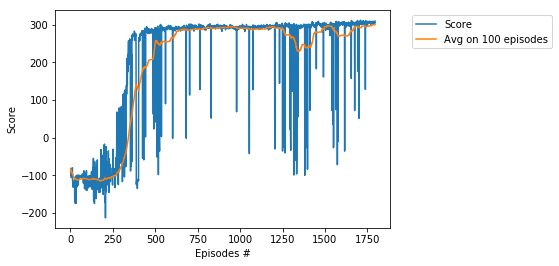

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [7]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=7)


Episode 1	Average Score: 304.17,	Score: 304.17 	Time: 00:00:16
Episode 2	Average Score: 304.81,	Score: 305.44 	Time: 00:00:12
Episode 3	Average Score: 305.16,	Score: 305.87 	Time: 00:00:12
Episode 4	Average Score: 305.21,	Score: 305.34 	Time: 00:00:12
Episode 5	Average Score: 305.14,	Score: 304.86 	Time: 00:00:12
Episode 6	Average Score: 304.79,	Score: 303.05 	Time: 00:00:13
Episode 7	Average Score: 304.80,	Score: 304.90 	Time: 00:00:12


In [8]:
env.close()